In [31]:
import os
from os.path import exists
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, ConvLSTM2D, Conv2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift

import matplotlib.pyplot as plt
import math

from keras import backend as K

import time
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
import MetaTrader5 as mt5

Num GPUs Available:  1


In [36]:
# -------------------------------------------
# Constan
# -------------------------------------------
# NumF = 1*24*60*60//24
# NumP = 24*60*60//24//10
# size_Reduce = (30*3)
minni_add = 15
#mt5Range_time = mt5.TIMEFRAME_M15
maxCntCore = 100*24*60//minni_add
NumDataTrain = 60*24*60//minni_add
NumDataPerTest = 10*24*60//minni_add
NumF = 24*60//minni_add
NumP = 15//minni_add
size_Reduce = 1
min_delta_cmp = 200
nameFile = "data_BTCUSDm"
type_tick = "BTCUSDm"

In [43]:
# -------------------------------------------
# Function
# -------------------------------------------
def hour_rounder(t):
    return t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
    
def demathPre(xValue, plus=False):
  global max_value, min_value, scaler
  xValue = scaler.inverse_transform(xValue.reshape((-1, 1)))
  xValue = np.float64(xValue)
  
  if plus:
    # xValue = xValue ** (1 / 4.0)
    # xValue/=pow(10, 8)
    #xValue*=max_value
    xValue+=min_value
  #xValue = np.vectorize(lambda x: int(x >= 0.5))(xValue)
  return np.round(xValue, 6)
  
  return np.round(xValue, 2)
  #return np.round(xValue, 4)
def enmathPre(xValue, no_fit=False):
  global max_value, min_value, scaler
  
  xValue-=min_value
  #xValue/=max_value
  # xValue*=pow(10, 8)
  # xValue**=4
  
  if not no_fit:
    scaler.fit(xValue.reshape((-1, 1)))
  xValue = scaler.transform(xValue.reshape((-1, 1)))
  return xValue.reshape((-1,4))
def formatDataset(data, dataForY, scaler_x, num_in, num_out):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x - (NumF//size_Reduce - 1)
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  y = np.zeros((numData, num_out), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
    for j in range(0, num_out):
        y[i] = data[i+scaler_x+j+(NumF//size_Reduce - 1)][3]
      # y[i] = (dataForY[i+scaler_x+j+5] >= dataForY[i+scaler_x+j+11])
  return (x, y)
def formatDataPredist(data, scaler_x, num_in):
  global NumF, NumP, size_Reduce
  numData = len(data) - scaler_x
  x = np.zeros((numData, scaler_x, num_in), dtype = np.float64)
  for i in range(0, numData):
    x_child = np.zeros((scaler_x, num_in), dtype = np.float64)
    for j in range(0, scaler_x):
      x_child[j] = data[i + j]
    x[i] = x_child;
  return x
def predictCon(input_dims, scale_x, scale_y, data):
  global model, np, random
  test_x = np.zeros((scale_x, input_dims))
  for i in range(0, scale_x):
    test_x[i] = data[i]
  test_y = np.zeros((len(data) - scale_x,  scale_y))
  for i in range(0, len(data) - scale_x):
    test_y[i] = model.predict(test_x.reshape((1, scale_x, input_dims))).T[0][0]
    shift(test_x, -scale_y, cval=np.zeros((input_dims)))
    for j in range(scale_x-scale_y, scale_x):
      test_x[j] = test_y[i][j - scale_x + scale_y] + (random.random()*2*0.03 - 0.035)
  return test_y
def extract_seqX_outcomeY(data, scale_x, input_dims):
  test_x = np.zeros((len(data) - scale_x, scale_x, input_dims), dtype = np.float64)
  for i in range(0, len(data) - scale_x):
    test_x_child = data[i:i+scale_x]
    test_x[i] = test_x_child;
  return test_x
def DrawPlot(data, up_x, label, date = [], step = 1, noinv = False):
  global demathPre
  tranfor = demathPre
  if tranfor and (not noinv):
    data = tranfor(data)
  if len(date) == 0:
    date = np.zeros(data.shape)
    for i in range(0, len(data), step):
      date[i] = i + up_x
  # print(data.shape, date.shape)
  plt.plot(date, data, label = label)
def reduceSizeArr(data, child_size):
  num_child = len(data)//child_size
  child_arr = np.zeros((num_child, 4), dtype = np.float64);
  for i in range(0, num_child):
    child_value = 0.0;
    for j in range(0, child_size):
      child_value = child_value + data[i*child_size + j]/child_size
    child_arr[i] = child_value;
  return child_arr
def calPrize(val_l, val_r, mode):
  re_val = (val_l[3] - val_r[3])*mode
  return re_val;
def find_best_pos(data):
  minest = data.argmin()
  maxest = data.argmax()
  return (min(minest, maxest), max(minest, maxest))
def fomatDataFinal(data):
    global input_dims, NumBack
    X_beta = data.reshape((input_dims, -1, NumBack))
    X_time = X_beta[input_dims - 1]
    # create training data from non time values
    X_non_time = np.zeros((input_dims-1, len(X_beta[0]), NumBack), dtype=np.float64)
    for i in range(0, input_dims-1):
        X_non_time[i] = X_beta[i]
    X_non_time = X_non_time.reshape((-1,input_dims - 1, NumBack))
    return [X_time, X_non_time]

In [38]:
# connect to MetaTrader 5
if not mt5.initialize(login=96414403, password="8zVtw5FGfc4bvus", server='Exness-MT5Trial6'):
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
 
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=3337, maxbars=100000, codepage=0, ping_last=38272, community_balance=0.0, retransmission=0.0, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\nhson\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 3337, '30 Jun 2022')


In [39]:
# -------------------------------------------
# Get data realtime
# -------------------------------------------
cntCore = []

# file_exists = exists(nameFile)
file_exists = False
if file_exists == False:
    timezone = datetime.timezone.utc
    utc_from = datetime.datetime.now(timezone)
    Data_ticks = mt5.copy_rates_from(type_tick, mt5Range_time, utc_from, maxCntCore)
    # BTCUSDm
    SStock = datetime.datetime.utcfromtimestamp(Data_ticks[len(Data_ticks)-1]['time'].item()) + datetime.timedelta(hours=7)
    data = np.zeros((len(Data_ticks), 4), dtype = np.float64)
    for i in range(0, len(data)):
      data[i][0] = Data_ticks[i]['open']
      data[i][1] = Data_ticks[i]['high']
      data[i][2] = Data_ticks[i]['low']
      data[i][3] = Data_ticks[i]['close']
    SaveData = np.copy(data)
    with open(nameFile, 'wb') as f:
        np.save(f, SaveData)
else:
    with open(nameFile, 'rb') as f:
        SaveData = np.load(f)

min_value = np.min(SaveData)
max_value = np.max(SaveData)
scaler = StandardScaler()

In [40]:
print(SaveData.shape);

(9600, 4)


In [41]:
print(SaveData)

[[46740.48 46893.8  46675.83 46855.25]
 [46852.33 46856.98 46680.28 46717.97]
 [46722.19 46791.77 46626.83 46784.17]
 ...
 [20474.44 20475.26 20411.38 20463.33]
 [20461.13 20462.65 20407.25 20440.64]
 [20442.5  20451.5  20439.45 20449.14]]


In [45]:
print(enmathPre(np.copy(SaveData)))

[[ 1.90211719  1.9207922   1.89424255  1.91609665]
 [ 1.91574099  1.91630738  1.89478458  1.89937538]
 [ 1.89988939  1.90836453  1.88827415  1.90743881]
 ...
 [-1.29719557 -1.29709569 -1.30487654 -1.29854882]
 [-1.29881679 -1.29863164 -1.30537959 -1.30131255]
 [-1.301086   -1.29998976 -1.3014575  -1.30027722]]


In [48]:
# -------------------------------------------
# Format size data
# -------------------------------------------
noChangeData = np.copy(SaveData)
lenData = NumDataTrain*size_Reduce+(NumF)
orgData = np.copy(noChangeData[len(noChangeData)-lenData:])
# test_orgData = np.copy(orgData) * 10000
test_orgData = np.copy(orgData)
orgData = reduceSizeArr(orgData, size_Reduce)
print(noChangeData.shape, orgData.shape)

orgData = enmathPre(orgData, no_fit=True)

data = np.copy(orgData[:len(orgData) - (NumF//size_Reduce)])
dataForY = np.copy(test_orgData[:len(test_orgData) - (NumF//size_Reduce)])
print(data.shape)

(9600, 4) (5856, 4)
(5760, 4)


In [49]:
# -------------------------------------------
# Model configuration
# -------------------------------------------
additional_metrics = [] #['binary_accuracy']
batch_size = 300
input_dims = 4
output_dims = 1
loss_function = "mean_squared_error" #"mean_squared_error" "binary_crossentropy"
number_of_epochs = 30
optimizer = Adam()
validation_split = 0.01
verbosity_mode = 1

In [50]:
# -------------------------------------------
# Format data
# -------------------------------------------
(x_train, y_train) = formatDataset(data, dataForY, batch_size, input_dims, output_dims)
print(x_train.shape, y_train.shape)

(5365, 300, 4) (5365, 1)


In [51]:
# -------------------------------------------
# Building model
# -------------------------------------------
# Define the Keras model
model = Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(batch_size, input_dims)))
model.add(LSTM(batch_size, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(batch_size, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(batch_size))
model.add(Dropout(0.1))
model.add(Dense(output_dims, activation=tf.keras.activations.linear))
# model.add(Dense(output_dims, activation=tf.keras.activations.sigmoid))
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
# Give a summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 300, 300)          366000    
                                                                 
 dropout_6 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_7 (LSTM)               (None, 300, 300)          721200    
                                                                 
 dropout_7 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_8 (LSTM)               (None, 300)               721200    
                                                                 
 dropout_8 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [52]:
# -------------------------------------------
# Train model
# -------------------------------------------
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, mode="min", min_delta=0.001, restore_best_weights=True) #,min_delta=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,min_delta=0.001, mode="min", restore_best_weights=True,)
history = model.fit(x_train, y_train, validation_split=validation_split, batch_size=64, epochs=number_of_epochs, verbose=verbosity_mode, callbacks=[], shuffle=False) #, shuffle=True, callbacks=[early_stopping])

Epoch 1/30
83/83 [==============================] - 28s 250ms/step - loss: 0.0544 - val_loss: 0.0318
Epoch 2/30
83/83 [==============================] - 19s 233ms/step - loss: 0.0591 - val_loss: 0.0166
Epoch 3/30
83/83 [==============================] - 19s 234ms/step - loss: 0.0802 - val_loss: 0.0032
Epoch 4/30
83/83 [==============================] - 19s 235ms/step - loss: 0.1211 - val_loss: 0.0012
Epoch 5/30
83/83 [==============================] - 19s 235ms/step - loss: 0.1876 - val_loss: 0.0370
Epoch 6/30
83/83 [==============================] - 19s 235ms/step - loss: 0.1480 - val_loss: 0.0052
Epoch 7/30
83/83 [==============================] - 20s 236ms/step - loss: 0.2129 - val_loss: 0.0121
Epoch 8/30
83/83 [==============================] - 20s 238ms/step - loss: 0.3086 - val_loss: 0.0299
Epoch 9/30
83/83 [==============================] - 20s 239ms/step - loss: 0.5321 - val_loss: 0.0556
Epoch 10/30
83/83 [==============================] - 20s 236ms/step - loss: 0.4427 - val_lo

In [53]:
model.save_weights("./exai_big.h", overwrite=True, save_format=None, options=None)

In [ ]:
model.load_weights('./exai_big.h')

 10


(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 6s 64ms/step
(1, 96)
70 95
Predist:  29467.575781  /  29682.729102
Result:  Buy
CMP l:  [38780.49 39095.65 38765.14 38957.17]
CMP r:  [39308.04 39309.98 39161.19 39231.  ]
21/21 [==============================] - 8s 74ms/step


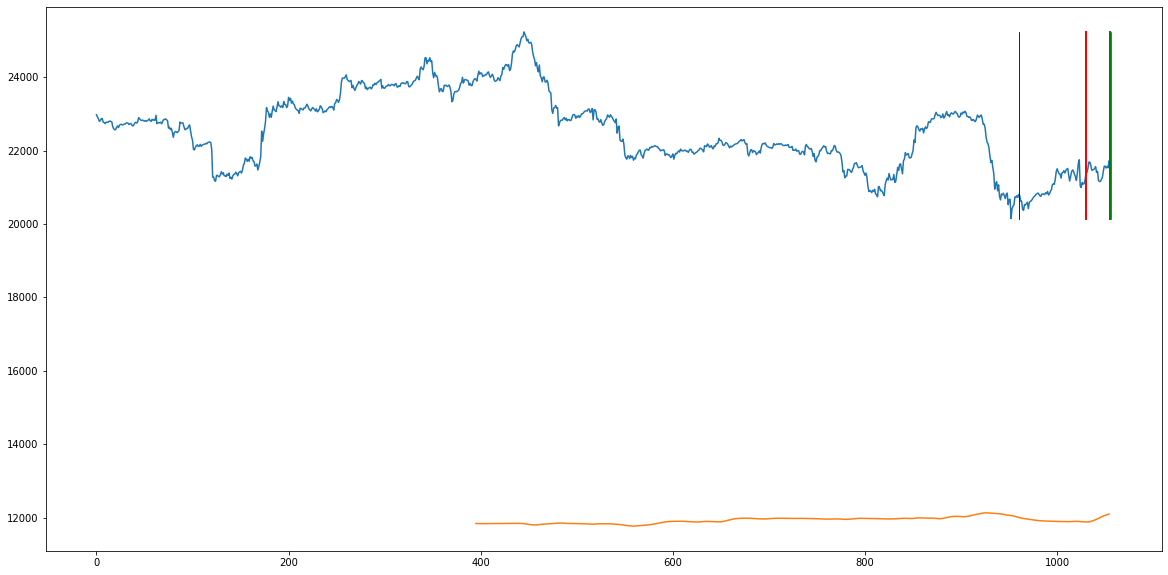

Bonus:  273.83000000000175
Acc money 10273.830000000002
Loop:  1  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 139ms/step
(1, 96)
45 78
Predist:  24172.395117  /  24172.391211
Result:  No BUY!
CMP l:  [19878.06 19945.84 19855.19 19945.84]
CMP r:  [20209.59 20221.1  20143.92 20173.25]
21/21 [==============================] - 2s 65ms/step


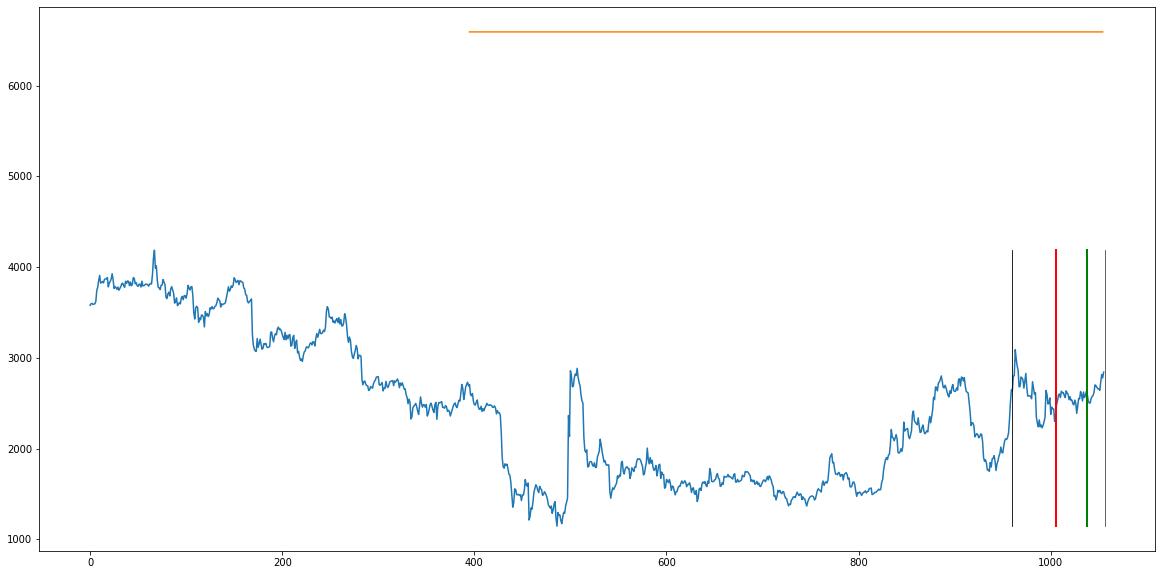

Bonus:  0
Acc money 10273.830000000002
Loop:  2  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 100ms/step
(1, 96)
11 68
Predist:  24172.390234  /  24172.393164
Result:  No BUY!
CMP l:  [20322.76 20363.69 20233.15 20255.21]
CMP r:  [19409.76 19450.2  19372.59 19444.62]
21/21 [==============================] - 1s 61ms/step


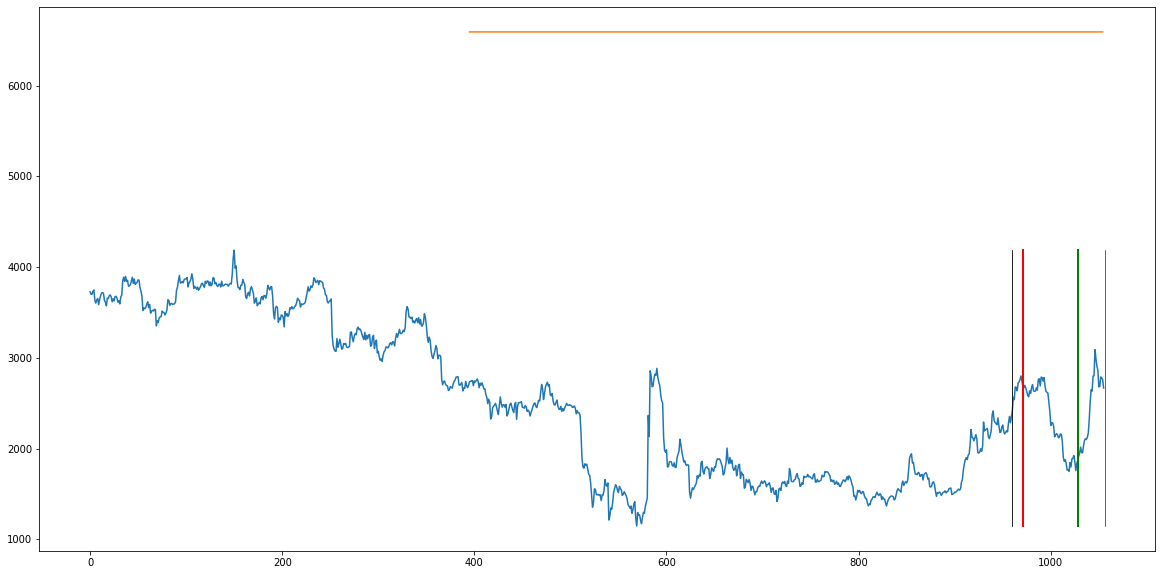

Bonus:  0
Acc money 10273.830000000002
Loop:  3  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 138ms/step
(1, 96)
10 43
Predist:  24172.395117  /  24172.391211
Result:  No BUY!
CMP l:  [19878.06 19945.84 19855.19 19945.84]
CMP r:  [20209.59 20221.1  20143.92 20173.25]
21/21 [==============================] - 1s 60ms/step


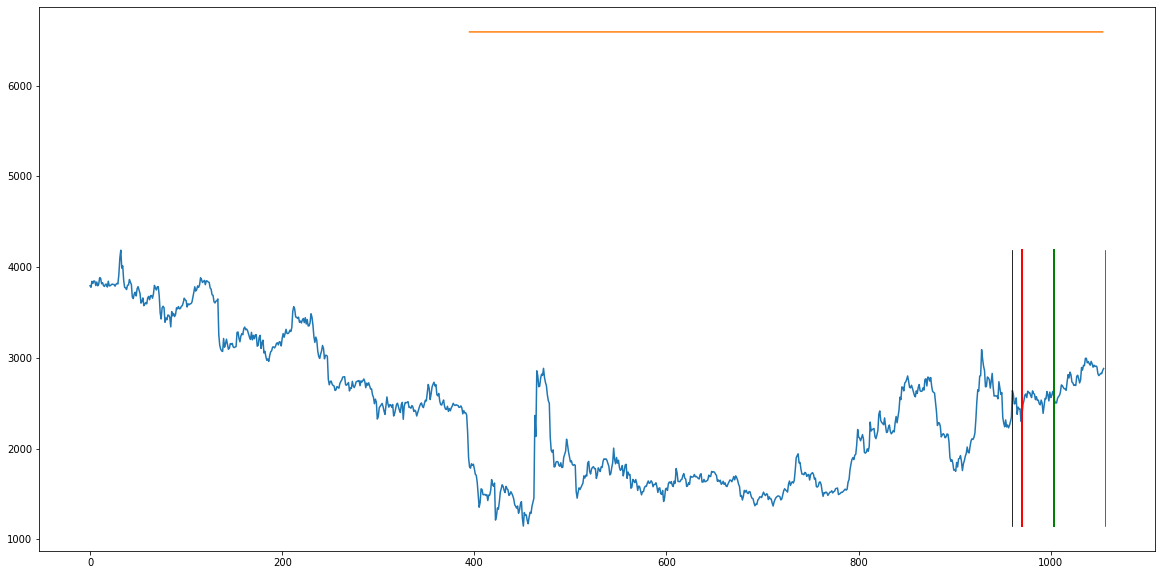

Bonus:  0
Acc money 10273.830000000002
Loop:  4  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 110ms/step
(1, 96)
0 15
Predist:  24172.449316  /  24172.450781
Result:  No BUY!
CMP l:  [29769.66 29777.3  29734.1  29743.  ]
CMP r:  [29826.37 29850.83 29757.64 29759.51]
21/21 [==============================] - 1s 61ms/step


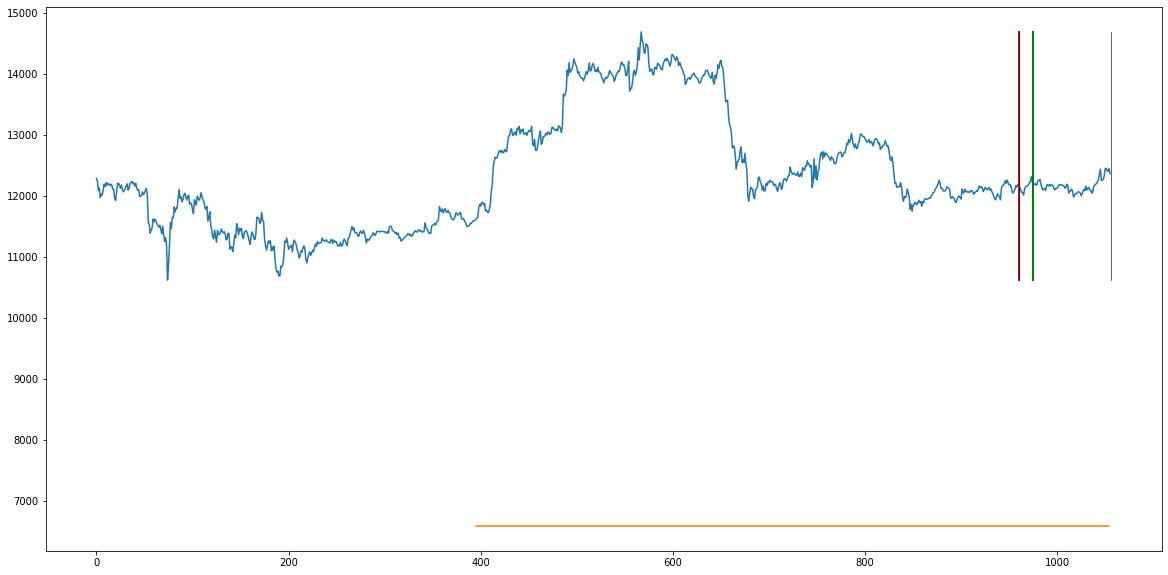

Bonus:  0
Acc money 10273.830000000002
Loop:  5  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 83ms/step
(1, 96)
0 65
Predist:  29769.589453  /  29913.05625
Result:  No BUY!
CMP l:  [38655.98 38737.7  38655.98 38689.65]
CMP r:  [38527.28 38533.36 38335.82 38425.97]
21/21 [==============================] - 1s 61ms/step


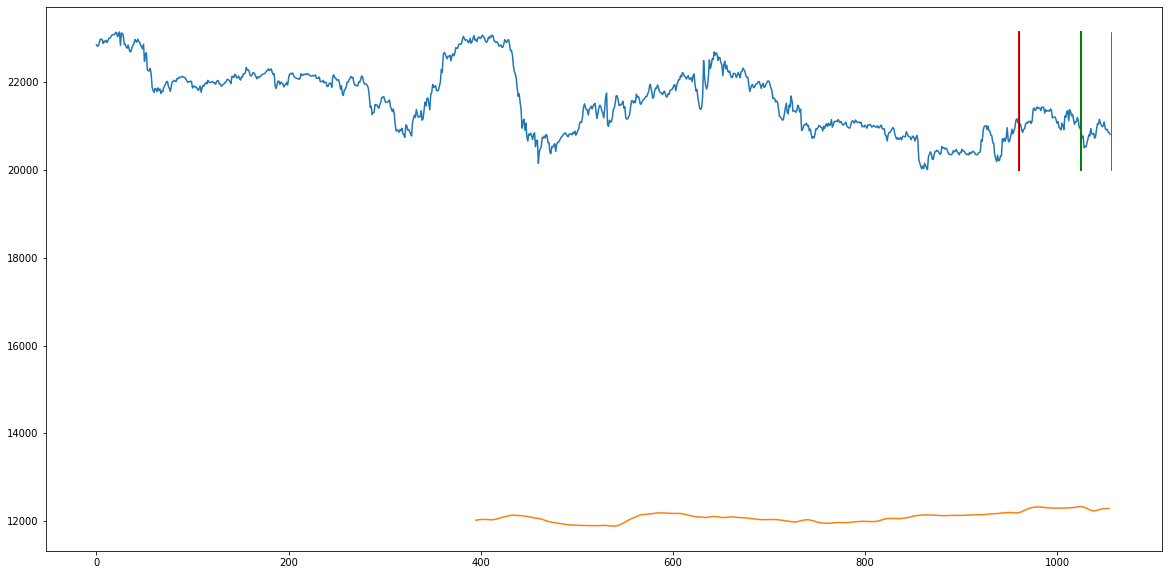

Bonus:  0
Acc money 10273.830000000002
Loop:  6  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 158ms/step
(1, 96)
0 83
Predist:  24172.449316  /  24172.441016
Result:  No BUY!
CMP l:  [28813.82 28859.88 28770.76 28859.44]
CMP r:  [28979.5  29011.93 28945.56 28958.58]
21/21 [==============================] - 1s 61ms/step


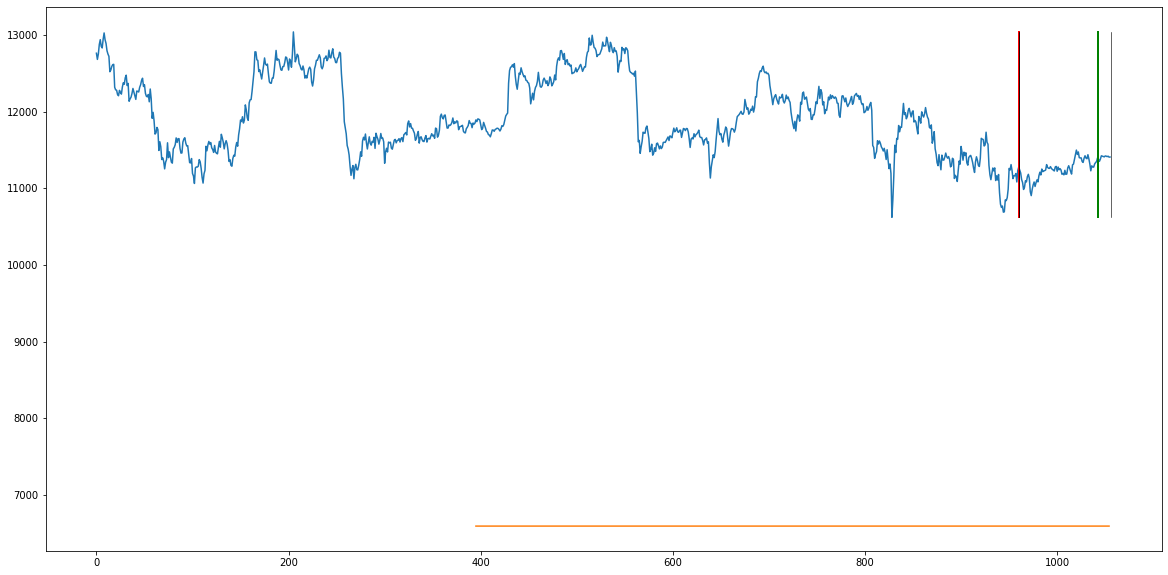

Bonus:  0
Acc money 10273.830000000002
Loop:  7  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 177ms/step
(1, 96)
20 95
Predist:  24172.455664  /  24172.445898
Result:  No BUY!
CMP l:  [29336.24 29376.21 29311.82 29362.89]
CMP r:  [29982.56 30053.31 29946.37 30019.63]
21/21 [==============================] - 1s 60ms/step


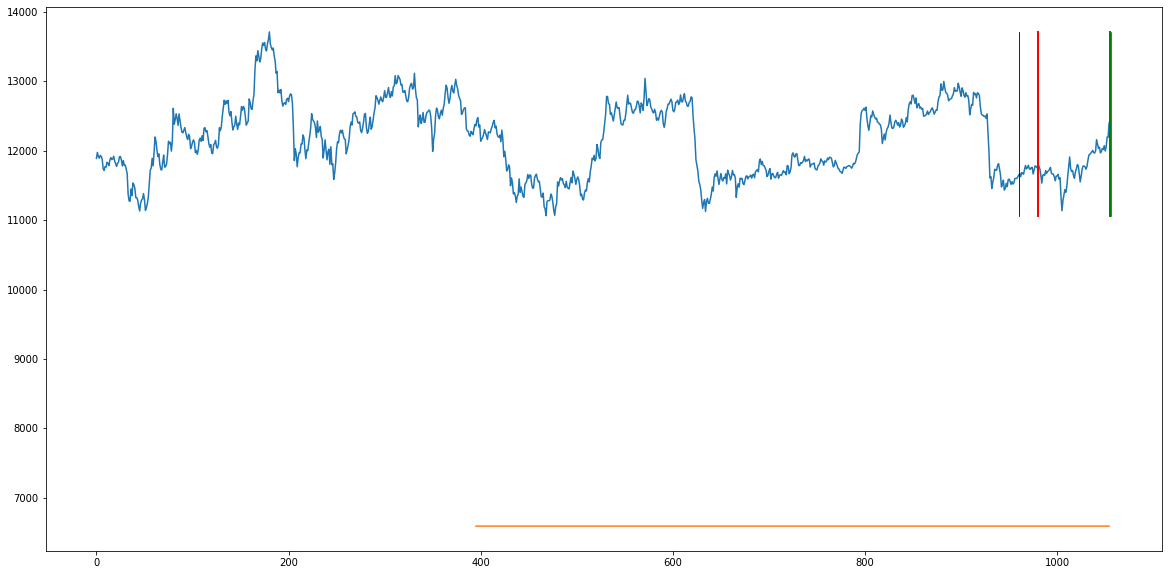

Bonus:  0
Acc money 10273.830000000002
Loop:  8  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 106ms/step
(1, 96)
7 48
Predist:  24172.400488  /  24172.395117
Result:  No BUY!
CMP l:  [20589.22 20821.82 20576.87 20809.17]
CMP r:  [20463.08 20473.33 20378.84 20408.4 ]
21/21 [==============================] - 1s 60ms/step


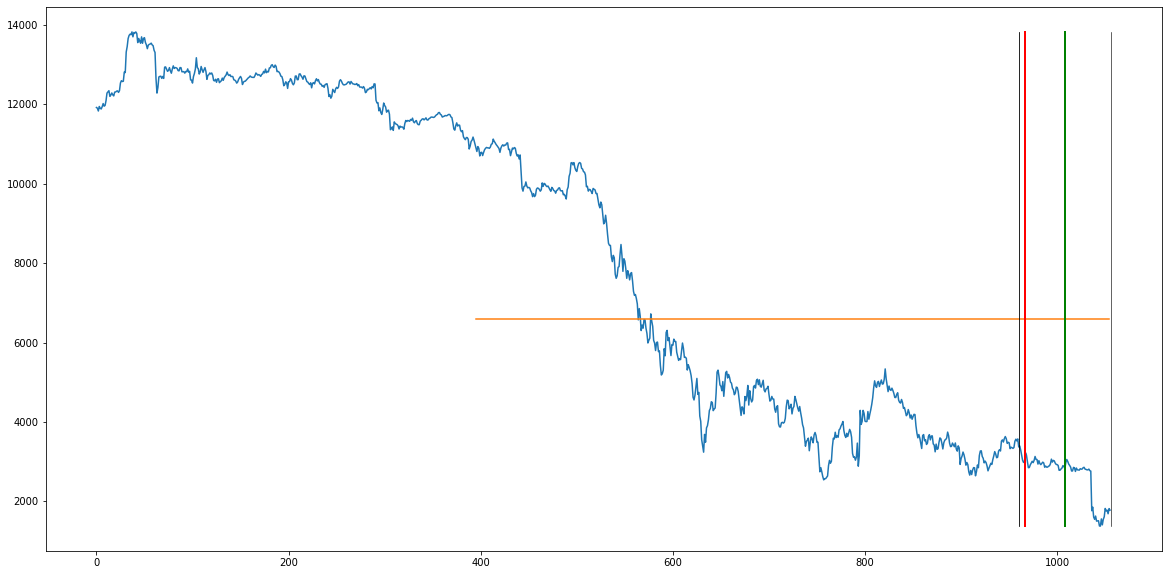

Bonus:  0
Acc money 10273.830000000002
Loop:  9  /  10  | win(  1  ) / loss(  0  )
(9600, 4) (1056, 4)
(960, 4)
(96, 300, 4)
3/3 [==============================] - 0s 168ms/step
(1, 96)
42 93
Predist:  24172.393652  /  24172.4
Result:  No BUY!
CMP l:  [20658.82 20822.39 20626.93 20795.47]
CMP r:  [20192.1  20310.41 20188.41 20244.72]
21/21 [==============================] - 1s 63ms/step


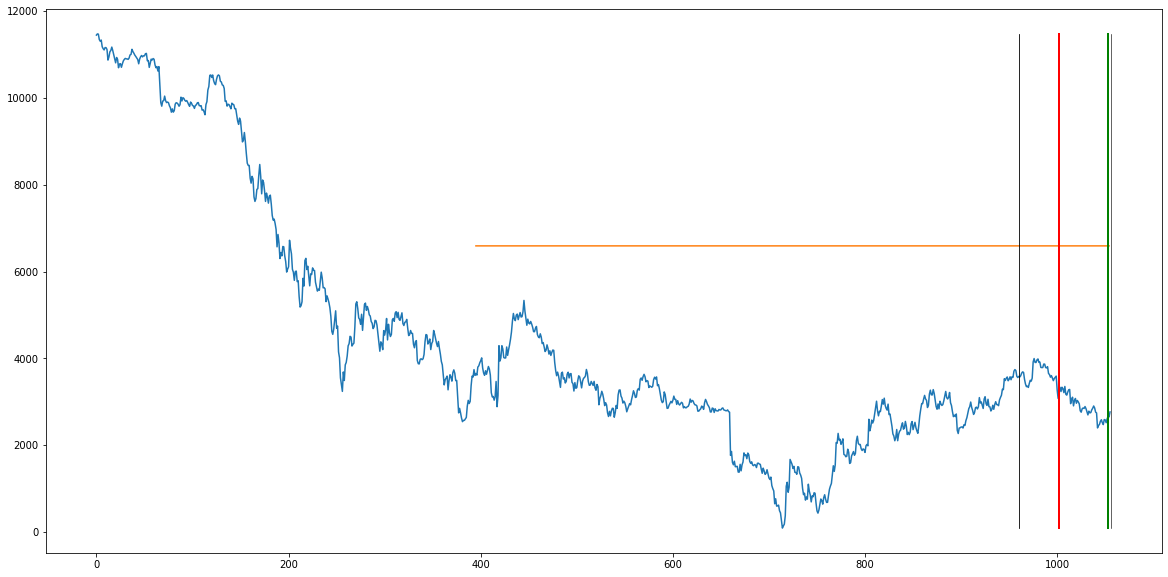

Bonus:  0
Acc money 10273.830000000002
Loop:  10  /  10  | win(  1  ) / loss(  0  )


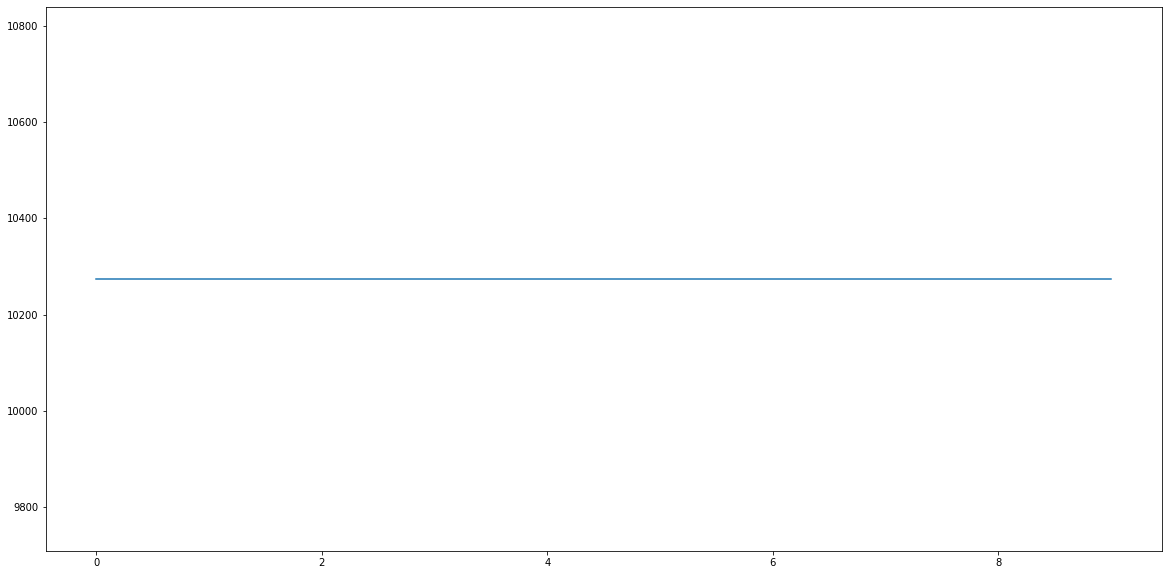

In [54]:
# -------------------------------------------
# Function AI
# -------------------------------------------
def runAI(noChangeData):
  global scaler, NumF, NumP, size_Reduce, NumDataPerTest, model
  # -------------------------------------------
  # Format size data
  # -------------------------------------------
  lenData = NumDataPerTest*size_Reduce+(NumF)
  ranPos = np.random.randint(lenData, len(noChangeData) + 1)
  orgData = np.copy(noChangeData[len(noChangeData)-ranPos:len(noChangeData)-ranPos+lenData])
  # test_orgData = np.copy(orgData) * 10000
  test_orgData = np.copy(orgData)
  orgData = reduceSizeArr(orgData, size_Reduce)
  print(noChangeData.shape, orgData.shape)

  orgData = enmathPre(orgData, no_fit=True)

  data = np.copy(orgData[:len(orgData) - (NumF//size_Reduce)])
  dataForY = np.copy(test_orgData[:len(test_orgData) - (NumF//size_Reduce)])
  print(data.shape)

  # -------------------------------------------
  # Real result
  # -------------------------------------------
  pos_predist_data = len(data)-1*batch_size-(NumF - NumP + 1)
  test_last_x_All = np.copy(data[pos_predist_data:])
  test_last_x_All = formatDataPredist(test_last_x_All, batch_size, input_dims)
  print(test_last_x_All.shape)
  test_last_y_All = model.predict(test_last_x_All)
  test_last_y_All = demathPre(test_last_y_All, plus=True).T
  print(test_last_y_All.shape)

  (pos_l, pos_r) = find_best_pos(test_last_y_All);
  print(pos_l, pos_r)
  BackPrize = test_last_y_All[0][pos_l]
  test_last_y = test_last_y_All[0][pos_r]
  
  #BackPrize = test_orgData[len(test_orgData)-7] / 10000
  print("Predist: ", BackPrize, " / ", test_last_y)
  test_sellorbuy = (BackPrize - test_last_y >= min_delta_cmp)
  test_NoBuyNoSell = (abs(BackPrize - test_last_y) <= min_delta_cmp)
  print("Result: ", ("No BUY!" if test_NoBuyNoSell else ("Sell" if test_sellorbuy else "Buy"))) 
  
  orgData_close = np.zeros((len(orgData)), dtype = np.float64);
  for i in range(0, len(orgData)):
    orgData_close[i] = orgData[i][3]
  
  len_range = (NumF - NumP + 1)
  print("CMP l: ", test_orgData[len(test_orgData) - len_range + pos_l])
  print("CMP r: ", test_orgData[len(test_orgData) - len_range + pos_r])

  CopyData = np.copy(data)
  fig = plt.figure(figsize = (20,10))
  test_x = extract_seqX_outcomeY(CopyData, np.copy(batch_size), input_dims)
  test_y = model.predict(test_x)
  DrawPlot(orgData_close, 0, 'Train 0', date = [], step = 1)
  DrawPlot(test_y.T[0], np.copy(batch_size) + (NumF - 1)//size_Reduce, 'Predicted Closing Price', date = [], step = 1)
  valSpitPos = len(orgData_close)
  minline = np.min(demathPre(orgData_close))
  maxline = np.max(demathPre(orgData_close))


  plt.plot([valSpitPos - len_range + pos_l, valSpitPos - len_range + pos_l], [minline, maxline], 'r-', lw=2)
  plt.plot([valSpitPos - len_range + pos_r, valSpitPos - len_range + pos_r], [minline, maxline], 'g-', lw=2)

  plt.plot([valSpitPos-(NumF//size_Reduce), valSpitPos-(NumF//size_Reduce)], [minline, maxline], 'k-', lw=0.6)
  plt.plot([valSpitPos, valSpitPos], [minline, maxline], 'k-', lw=0.6)
  plt.plot([valSpitPos-(NumF - NumP + 1)//size_Reduce, valSpitPos-(NumF - NumP + 1)//size_Reduce], [minline, maxline], 'k-', lw=0.6)
  plt.show()
    
  """
  fig = plt.figure(figsize = (20,10))
  DrawPlot(orgData, 0, 'Train 0', date = [])
  test_x = extract_seqX_outcomeY(orgData, batch_size, input_dims)
  test_y = model.predict(test_x)
  for i in range(0, 1):
      DrawPlot(test_y.T[i], batch_size + 11 + i, 'Predicted Closing Price (' + str(i) + ')', date = [])
  plt.show()
  """
  
  # -------------------------------------------
  # Print output
  # -------------------------------------------
  pos_evel = int(len(x_train)*(1.0-validation_split))
  #scores = model.evaluate(x_train[:pos_evel], y_train[:pos_evel], verbose=0)
  #print("Accuracy see: %.2f%%" % (scores[1]*100), y_train[:pos_evel].shape)
  if test_NoBuyNoSell:
    return 0
  elif test_sellorbuy == 1:
    return calPrize(test_orgData[len(test_orgData) - len_range + pos_l], test_orgData[len(test_orgData) - len_range + pos_r], 1)
  elif test_sellorbuy == 0:
    return calPrize(test_orgData[len(test_orgData) - len_range + pos_l], test_orgData[len(test_orgData) - len_range + pos_r], -1)
  
  return 0
    
Money = 10000
numItems = 1
arrMoney = []
numLoop = int(input())
winG = 0
lossG = 0
for i in range(0, numLoop):
  newSaveData = np.copy(SaveData)
  status = runAI(newSaveData)
  if status > 0:
    winG = winG + 1
  if status < 0:
    lossG = lossG + 1
  print("Bonus: ", status*numItems)
  Money = Money + status*numItems
  print("Acc money", Money)
  arrMoney.append(Money)
  print("Loop: ", (i+1), " / ", numLoop, " | win( ", winG, " ) / loss( ", lossG, " )")
  #time.sleep(0.6)

fig = plt.figure(figsize = (20,10))
arrMoney = np.array(arrMoney)
DrawPlot(arrMoney, 0, 'Acc money', date = [], noinv=True)
plt.show()